In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout,SimpleRNN


In [ ]:
data = yf.download('AAPL', start='2021-01-01', end='2024-12-31')

/tmp/ipython-input-900181154.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2021-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


In [ ]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2021-01-04,126.096611,130.189072,123.514460,130.101380,143301900
2021-01-05,127.655624,128.366944,125.141681,125.589909,97664900
2021-01-06,123.358536,127.694603,123.144167,124.449862,155088000
2021-01-07,127.567909,128.259737,124.586260,125.073458,109578200
2021-01-08,128.669006,129.234158,126.895598,129.039267,105158200


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1004 entries, 2021-01-04 to 2024-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1004 non-null   float64
 1   (High, AAPL)    1004 non-null   float64
 2   (Low, AAPL)     1004 non-null   float64
 3   (Open, AAPL)    1004 non-null   float64
 4   (Volume, AAPL)  1004 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 47.1 KB


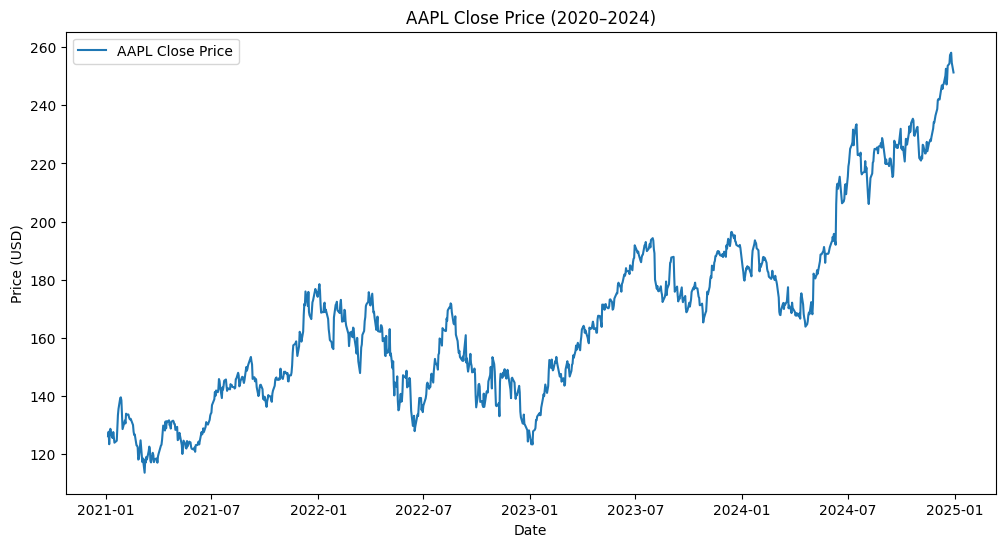

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='AAPL Close Price')
plt.title('AAPL Close Price (2020–2024)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [ ]:
df = data.copy()
#with help of AI
df['Returns'] = df['Close'].pct_change()
df['SMA_10'] = df['Close'].rolling(10).mean()
df['SMA_20'] = df['Close'].rolling(20).mean()
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['Volatility_10'] = df['Close'].rolling(10).std()
df['Momentum_5'] = df['Close'] - df['Close'].shift(5)
df['Lag_1'] = df['Close'].shift(1)
df['Lag_2'] = df['Close'].shift(2)
df['Avg_Return_5'] = df['Returns'].rolling(5).mean()

df = df.dropna().reset_index(drop=True)


In [ ]:
df.dropna(inplace=True)

print("\nColumns after feature engineering:")
print(df.columns)


Columns after feature engineering:
MultiIndex([(        'Close', 'AAPL'),
            (         'High', 'AAPL'),
            (          'Low', 'AAPL'),
            (         'Open', 'AAPL'),
            (       'Volume', 'AAPL'),
            (      'Returns',     ''),
            (       'SMA_10',     ''),
            (       'SMA_20',     ''),
            (       'EMA_10',     ''),
            (       'EMA_20',     ''),
            ('Volatility_10',     ''),
            (   'Momentum_5',     ''),
            (        'Lag_1',     ''),
            (        'Lag_2',     ''),
            ( 'Avg_Return_5',     '')],
           names=['Price', 'Ticker'])


In [ ]:
features = ['Open','High','Low','Close','Volume','SMA_10','SMA_20','Volatility_10','EMA_10','EMA_20','Momentum_5','Lag_1','Lag_2','Avg_Return_5']

target = 'Close'


In [ ]:
X = df[features].values
y = df[target].values.reshape(-1,1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

train_size = int(len(X_scaled)*0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 788, Test size: 197


In [ ]:
rnn = Sequential([
    SimpleRNN(128, return_sequences=True, input_shape=(seq_len, X_train_seq.shape[2])),
    Dropout(0.2),
    SimpleRNN(50),
    Dropout(0.2),
    Dense(1)
])

rnn.compile(optimizer='adam', loss='mse')
print("\nTraining RNN...")
rnn.fit(X_train_seq, y_train_seq, epochs=25, batch_size=32, validation_split=0.1, verbose=1)

y_pred_rnn = rnn.predict(X_test_seq)
y_pred_rnn = scaler_y.inverse_transform(y_pred_rnn)
y_test_seq_actual = scaler_y.inverse_transform(y_test_seq)


Training RNN...
Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.3522 - val_loss: 0.0451
Epoch 2/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1442 - val_loss: 0.0036
Epoch 3/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1194 - val_loss: 0.0096
Epoch 4/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0920 - val_loss: 0.0022
Epoch 5/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0510 - val_loss: 0.0087
Epoch 6/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0389 - val_loss: 0.0020
Epoch 7/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0414 - val_loss: 0.0014
Epoch 8/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0293 - val_loss: 8.1765e-04
Epoch 9/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0246 - val_loss: 6.7836e-04
Epoch 10/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0227 - val_loss: 0.0017
Epoch 11/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0252 - val_loss: 0.0013
Epoch 12/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0202

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
import numpy as np

def make_sequences(X, y, seq_len=60):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

seq_len = 60
X_train_seq, y_train_seq = make_sequences(X_train, y_train, seq_len)
X_test_seq, y_test_seq = make_sequences(X_test, y_test, seq_len)

In [ ]:
y_pred_rnn = rnn.predict(X_test_seq)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [ ]:

y_pred_rnn_np = np.array(y_pred_rnn)
y_test_seq_actual_np = np.array(y_test_seq_actual)

from sklearn.metrics import mean_squared_error
import numpy as np

mse_rnn = mean_squared_error(y_test_seq_actual_np, y_pred_rnn_np)
rmse_rnn = np.sqrt(mse_rnn)

print(f"RNN MSE: {mse_rnn:.4f}, RMSE: {rmse_rnn:.4f}")


RNN MSE: 51321.3043, RMSE: 226.5421


In [ ]:
def make_sequences(X, y, seq_len=60):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

seq_len = 60
X_train_seq, y_train_seq = make_sequences(X_train, y_train, seq_len)
X_test_seq, y_test_seq = make_sequences(X_test, y_test, seq_len)

lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(seq_len, X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

lstm.compile(optimizer='adam', loss='mse')
print("\nTraining LSTM...")
lstm.fit(X_train_seq, y_train_seq, epochs=25, batch_size=32, validation_split=0.1, verbose=1)

y_pred_lstm = lstm.predict(X_test_seq)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm)
y_test_seq_actual = scaler_y.inverse_transform(y_test_seq)

mse_lstm = mean_squared_error(y_test_seq_actual, y_pred_lstm)
print(f"\nLSTM MSE: {mse_lstm:.4f}")




Training LSTM...
Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - loss: 0.0244 - val_loss: 0.0018
Epoch 2/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 3/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0028 - val_loss: 0.0010
Epoch 4/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0024 - val_loss: 9.7360e-04
Epoch 5/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.0022 - val_loss: 8.6731e-04
Epoch 6/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 7/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0019 - val_loss: 7.9281e-04
Epoch 8/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 9/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0019 - val_loss: 7.5837e-04
Epoch 10/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 11/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 0.0017 - val_loss: 8.2966e-04
Epoch 12/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 10

In [ ]:
if(mse_lstm>mse_rnn):
  print("RNN is better")
else:
  print("LSTM is better")

LSTM is better


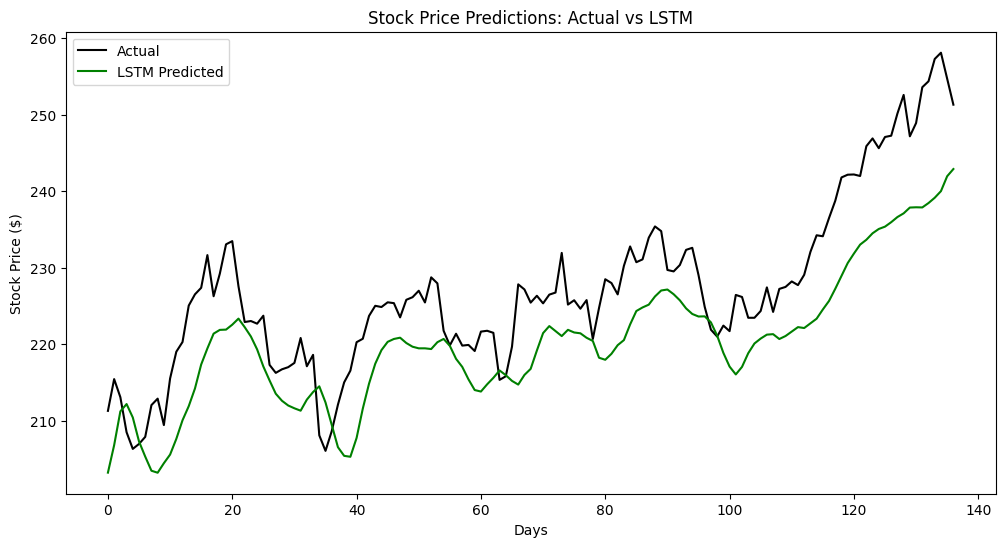

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test_seq_actual, label='Actual', color='black')
# plt.plot(y_pred_rnn, label='RNN Predicted', color='red')
plt.plot(y_pred_lstm, label='LSTM Predicted', color='green')
plt.title('Stock Price Predictions: Actual vs LSTM')
plt.xlabel('Days')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.show()


In [ ]:
import seaborn as sns
sns.heatmap(data, cmap='RdYlGn', annot=False, cbar=True)


In [ ]:
df.columns

In [ ]:
import seaborn as sns
sns.heatmap(df, annot=False, cbar=True)